# Cookie Cats Retention A/B Test Analysis

---


### Executive summary
A/B testing whether moving the first gate from level 30 to level 40 affects retention and engagement.

- **Primary metric (Day-7 retention)**  
  - Control rate (`gate_30`): 19.02% 
  - Treatment rate (`gate_40`): 18.20%
  - Δ = -0.82 pp with 95% CI [-1.33, -0.31], p-value = 0.0016, relative change = -4.31%
- **Decision rule:** Pre-specified MDE = 1.0 pp at α = 0.05.  
- **Outcome:** Fail, result is statistically significant but does not meet the MDE threshold (on the contrary, it harms retention).   

**Conclusion:** Based on the pre-specified criteria, the gate move to level 40 **is not recommended** for rollout.

In [42]:
# Executive Summary
# Uncomment and run this cell lastly, after running all cells below

# exec_summary = (
#    f"gate_30: {prop_ctrl_ret7:.2%} (95% CI [{ci_ctrl_low_ret7:.2%}, {ci_ctrl_high_ret7:.2%}])\n"
#    f"gate_40: {prop_treat_ret7:.2%} (95% CI [{ci_treat_low_ret7:.2%}, {ci_treat_high_ret7:.2%}])\n"
#    f"Delta at day 7: {delta_pp_ret7:.2f} pp (95% CI [{ci_low_delta7*100:.2f}, {ci_high_delta7*100:.2f}] pp), "
#    f"p={pval_ret7:.4f}, relative {rel_pct_ret7:.2f}%\n"
#    f"Decision: {decide(pval_ret7, delta_pp_ret7, mde_pp, alpha)}"
# )
# print(exec_summary)

### Project description

Cookie Cats is a mobile puzzle game developed by Tactile Entertainment. The game involves "gates" that serve as intentional breaks between levels, a system typical to puzzle games that boosts player enjoyment and play duration. In this project I will test whether moving the gate from level 30 to level 40 has a significant effect on player retention at day 7, using retention at day 1 and engagement as guardrail metrics. 

Dataset is sourced from [Kaggle](https://www.kaggle.com/datasets/mursideyarkin/mobile-games-ab-testing-cookie-cats).

`cookie_cats.csv`

| column | data type | description | 
|--------|-----------|-------------|
| `userid` | `int` | Unique player ID |
| `version` | `str` | Experiment split (``gate_30`` = control, ``gate_40`` = treatment) |
| `sum_gamerounds` | `int` | Total rounds per player |
| `retention_1` | `bool` | Active 1 day after installing the game |
| `retention_7` | `bool` | Active 7 days after installing the game |

Each row corresponds to 1 user.

I pre-specified day-7 retention as the primary metric, while specifying day-1 retention and game rounds as guardrails used diagnostically to catch unintended harmful effects.

**Primary metric:** Day-7 retention (``retention_7``).  
**Test applied:** Two-proportion z-test (α = 0.05, two-sided).  
**Power/MDE:** Target 80% power, operational MDE = 1.0 pp.  

- **H₀:** Gate move has no effect on D7 retention.
- **H₁:** Gate move changes D7 retention.

**Guardrails (diagnostic):**
- **Day-1 retention (``retention_1``):** z-test (same structure as primary).
- **Game rounds (``sum_gamerounds``):** Mann–Whitney U (non-parametric) and Welch's t-test on log-transformed data.
  - **H₀:** distributions are equal across groups.

**Multiple testing:** guardrail p-values corrected based on Holm method.

**Decision rule:** rollout only if
- D7 is significant (p < 0.05) AND uplift ≥ 1.0 pp. 
- Otherwise, fail or flag for review.

**Population:** Intention-to-treat (ITT).

**Sanity checks (Sample Ratio Test):**
- Chi-square test
- Exact binomial test

In [43]:
# Success criteria
primary_metric = "retention_7"  # day-7 retention
guardrail_metrics = [
    "retention_1",
    "sum_gamerounds",
]  # day-1 retention and sum of game rounds per player
alpha = 0.05  # 5% significance level
confidence_level = 1 - alpha  # 95% confidence level
power = 0.80  # 80% statistical power
mde_pp = 1.0  # pre-specified absolute uplift threshold in percentage points

### 1. Experiment setup

In [44]:
# Imports
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import binomtest, chisquare, mannwhitneyu, ttest_ind
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import (
    confint_proportions_2indep,
    proportion_confint,
    proportion_effectsize,
    proportions_ztest,
)

### 2. Load data & quick inspection

In [45]:
# Load the CSV and preview the data
cookie_df = pd.read_csv(r"data\cookie_cats.csv")
cookie_df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [46]:
cookie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [47]:
cookie_df.groupby("version")["userid"].nunique()

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64

### 3. Data cleaning & sanity checks

#### 3.1 Type conversions

In [48]:
# Convert retention values from boolean to integer
cookie_df[["retention_1", "retention_7"]] = cookie_df[
    ["retention_1", "retention_7"]
].astype(int)
cookie_df[["retention_1", "retention_7"]].head()

,retention_1,retention_7
0,0,0
1,1,0
2,1,0
3,0,0
4,1,1


#### 3.2 Missing values & duplicates

In [49]:
# Missing values per column
missing_values = cookie_df.isnull().sum()
print(f"Missing values per column: \n{missing_values}")

Missing values per column: 
userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64


In [50]:
# Check unique users and duplicates
unique_users = cookie_df["userid"].nunique()
duplicate_users = cookie_df[cookie_df.duplicated("userid", keep=False)]

print(f"Unique users: {unique_users}")
print(f"Duplicate users: {duplicate_users['userid'].unique()}")

Unique users: 90189
Duplicate users: []


#### 3.3 Outliers

Exploring outliers in ``sum_gamerounds`` distribution.

In [51]:
# Inspect top players with highest game rounds
cookie_df.sort_values("sum_gamerounds", ascending=False).head()

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,0,1
7912,871500,gate_30,2961,1,1
29417,3271615,gate_40,2640,1,0
43671,4832608,gate_30,2438,1,1
48188,5346171,gate_40,2294,1,1


**Note:** 49854 game rounds is physically impossible, this value is possibly not a naturally ocurring outlier but due to a data integrity error. The remaining top values are in the 2-3k range, indicating extreme player engagement (within normal constraints). I decided to remove the 50k row and use the filtered dataset (``plot_df``) only for the relevant plots on engagement so that they are better interpretable. The sanity checks and tests use the main dataset (``cookiecats_df``) and thus remain unaffected by this decision.

In [52]:
# Drop the anomalous value
plot_df = cookie_df[cookie_df["sum_gamerounds"] < 3000].copy()
plot_df.sort_values("sum_gamerounds", ascending=False).head()

,userid,version,sum_gamerounds,retention_1,retention_7
7912,871500,gate_30,2961,1,1
29417,3271615,gate_40,2640,1,0
43671,4832608,gate_30,2438,1,1
48188,5346171,gate_40,2294,1,1
46344,5133952,gate_30,2251,1,1


In [53]:
# Inspect game rounds distribution
percentiles = cookie_df["sum_gamerounds"].describe(
    percentiles=[0.5, 0.9, 0.95, 0.99, 0.999]
)
print(percentiles)

# IQR method
Q1 = cookie_df["sum_gamerounds"].quantile(0.25)
Q3 = cookie_df["sum_gamerounds"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Check outliers
outliers = cookie_df[
    (cookie_df["sum_gamerounds"] < lower_bound)
    | (cookie_df["sum_gamerounds"] > upper_bound)
]
print(
    f"Outliers detected: {len(outliers)} rows ({len(outliers) / len(cookie_df):.2%} of dataset)"
)

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
50%         16.000000
90%        134.000000
95%        221.000000
99%        493.000000
99.9%     1073.624000
max      49854.000000
Name: sum_gamerounds, dtype: float64


Outliers detected: 10177 rows (11.28% of dataset)


In [54]:
# Set uniform style for all plots
def set_plot_style():
    """Apply uniform style for plotting"""

    # Matplotlib parameters
    plt.rcParams["figure.figsize"] = [10, 6]
    plt.rcParams["font.size"] = 12
    plt.rcParams["axes.titlesize"] = 14
    plt.rcParams["axes.labelsize"] = 12
    plt.rcParams["xtick.labelsize"] = 10
    plt.rcParams["ytick.labelsize"] = 10
    plt.rcParams["legend.fontsize"] = 11
    plt.rcParams["figure.dpi"] = 100
    plt.rcParams["savefig.dpi"] = 500
    plt.rcParams["grid.alpha"] = 0.3

    # Seaborn style
    sns.set_style("whitegrid")

    # Set custom color palette
    custom_palette = ["#6B46C1", "#3182CE", "#63B3ED", "#BEE3F8", "#EBF8FF"]
    sns.set_palette(custom_palette)


set_plot_style()

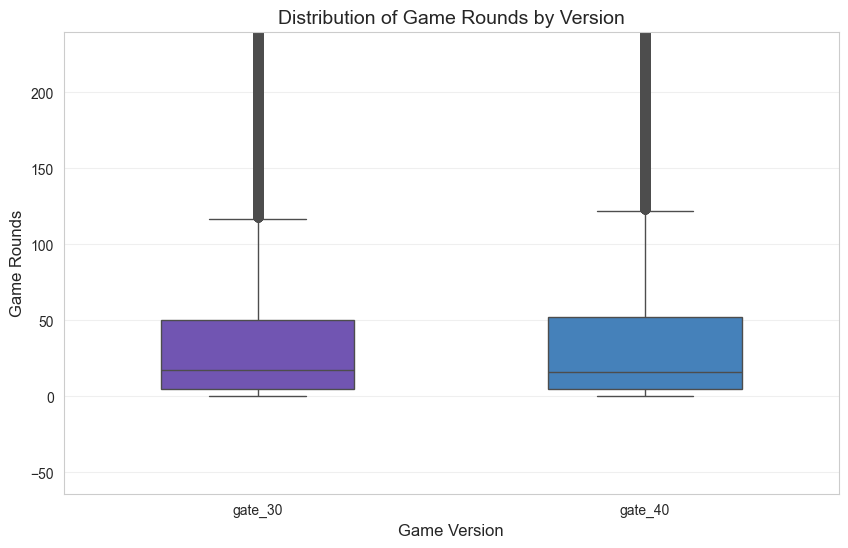

In [55]:
# Plot game rounds distribution
sns.boxplot(x="version", y="sum_gamerounds", data=plot_df, hue="version", width=0.5)
plt.title("Distribution of Game Rounds by Version")
plt.xlabel("Game Version")
plt.ylabel("Game Rounds")
plt.ylim(lower_bound, upper_bound * 2)
plt.show()

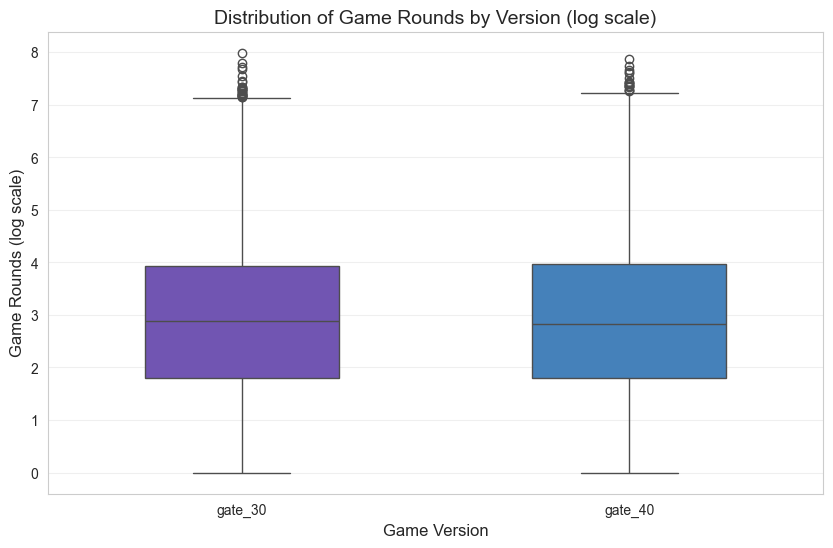

In [56]:
# Create a column to log-transform sum_gamerounds
plot_df.loc[:, "log_sum_gamerounds"] = np.log1p(plot_df["sum_gamerounds"])

# Plot game rounds distributions by version
sns.boxplot(
    x="version",
    y="log_sum_gamerounds",
    data=plot_df,
    hue="version",
    width=0.5,
)
plt.title("Distribution of Game Rounds by Version (log scale)")
plt.xlabel("Game Version")
plt.ylabel("Game Rounds (log scale)")
plt.show()

#### 3.5 Assignment counts & Sample Ratio Test

Conduct a sanity check for sample ratio mismatch (SRM) between versions ``gate_30`` (control group) and ``gate_40`` (treatment group).

In [57]:
# Assign unique player counts to variables
control_players = cookie_df[cookie_df["version"] == "gate_30"]["userid"].nunique()
treatment_players = cookie_df[cookie_df["version"] == "gate_40"]["userid"].nunique()
total_players = control_players + treatment_players

print(f"Unique control players: {control_players}")
print(f"Unique treatment players: {treatment_players}")
print(f"Total unique players: {total_players}")

Unique control players: 44700
Unique treatment players: 45489
Total unique players: 90189


In [58]:
# Create allocation ratios per version
control_perc = control_players / total_players
treatment_perc = treatment_players / total_players

print(f"Percentage of players in control group (gate_30): {control_perc:.2%}")
print(f"Percentage of players in treatment group (gate_40): {treatment_perc:.2%}")

Percentage of players in control group (gate_30): 49.56%
Percentage of players in treatment group (gate_40): 50.44%


In [59]:
# Create lists of observed and expected counts per version
observed = [control_players, treatment_players]
expected = [total_players / 2, total_players / 2]

# Run chi-square test for SRM
chi_stat, srm_chi2_pval = chisquare(f_obs=observed, f_exp=expected)

# Run exact binomial test for SRM
res = binomtest(k=control_players, n=total_players, p=0.5, alternative="two-sided")
srm_binom_pval = res.pvalue

print(f"SRM (chi-square) p = {srm_chi2_pval:6g} | (binomial) p = {srm_binom_pval:6g}")
print(
    f"Allocation ratio: control = {control_players} ({control_perc:.2%}), treatment = {treatment_players} ({treatment_perc:.2%})"
)

if min(srm_chi2_pval, srm_binom_pval) < 0.001:
    print("Strong SRM indication")
else:
    print("No strong SRM indication")

SRM (chi-square) p = 0.00860799 | (binomial) p = 0.00869223
Allocation ratio: control = 44700 (49.56%), treatment = 45489 (50.44%)
No strong SRM indication


### 4. Exploratory data analysis (EDA)

#### 4.1 Summary statistics

Mean, count, and standard deviation summary

In [60]:
# Retention summary statistics
cookie_df.groupby("version")[["retention_1", "retention_7"]].agg(
    ["mean", "std", "count"]
)

retention_1                  retention_7                 
               mean       std  count        mean       std  count
version                                                          
gate_30    0.448188  0.497314  44700    0.190201  0.392464  44700
gate_40    0.442283  0.496663  45489    0.182000  0.385849  45489

In [61]:
# Game rounds summary statistics
cookie_df.groupby("version")[["sum_gamerounds"]].agg(["mean", "std", "count"])

sum_gamerounds                   
                  mean         std  count
version                                  
gate_30      52.456264  256.716423  44700
gate_40      51.298776  103.294416  45489

#### 4.2 Assignment bar plot

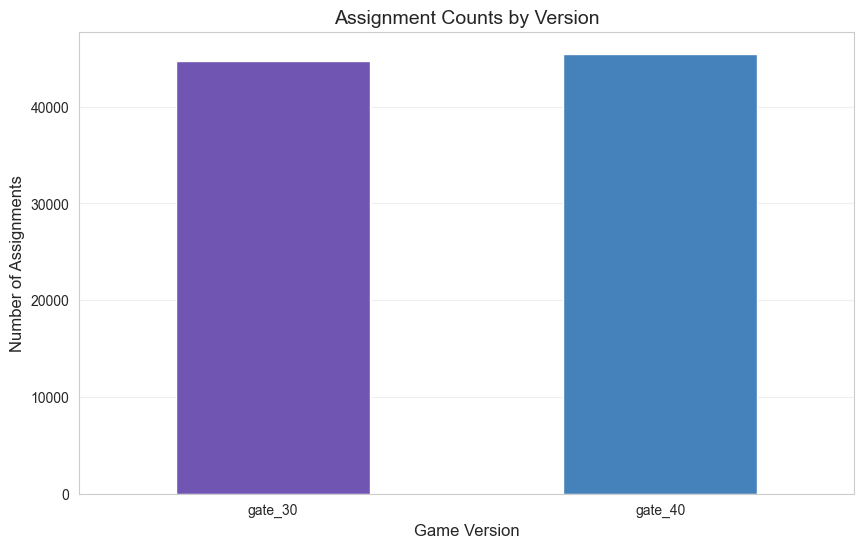

In [62]:
# Plot assignment counts by version
sns.countplot(x="version", data=cookie_df, hue="version", width=0.5)
plt.title("Assignment Counts by Version")
plt.xlabel("Game Version")
plt.ylabel("Number of Assignments")
plt.show()

#### 4.3 Retention rates (day-1 and day-7) with 95% CI

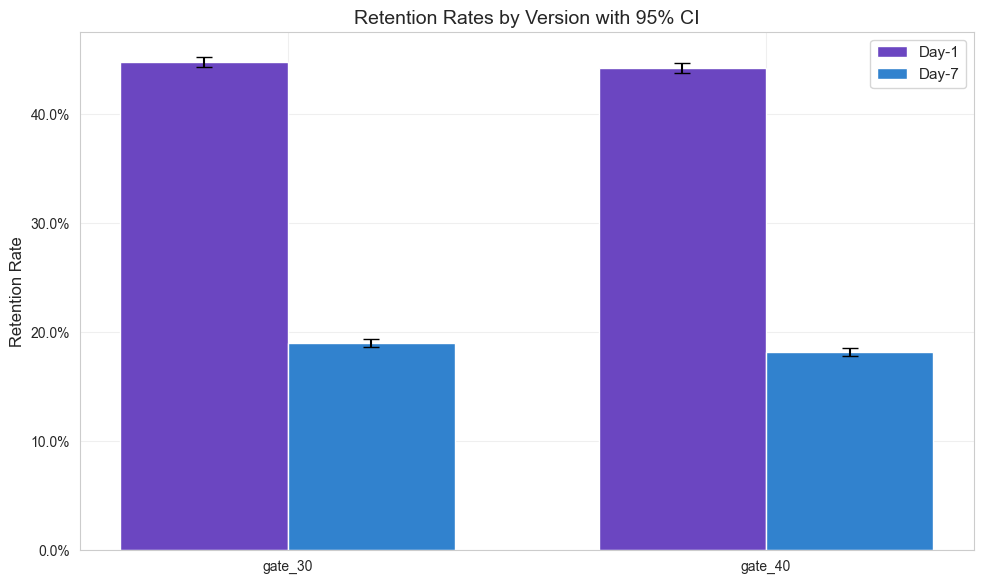

In [63]:
# Function to plot grouped bar with confidence intervals
def plot_grouped_bars_with_ci(df):
    # Build summary for both metrics
    rows = []
    for col, label in [("retention_1", "Day-1"), ("retention_7", "Day-7")]:
        agg = (
            df.groupby("version")[col]
            .agg(["sum", "count"])
            .rename(columns={"sum": "successes", "count": "n"})
        )
        agg["rate"] = agg["successes"] / agg["n"]
        agg[["ci_low", "ci_upp"]] = agg.apply(
            lambda r: pd.Series(
                proportion_confint(int(r["successes"]), int(r["n"]), method="wilson")
            ),
            axis=1,
        )
        agg = agg.loc[["gate_30", "gate_40"]]
        for v in agg.index:
            rows.append(
                dict(
                    metric=label,
                    version=v,
                    rate=agg.loc[v, "rate"],
                    err_low=agg.loc[v, "rate"] - agg.loc[v, "ci_low"],
                    err_upp=agg.loc[v, "ci_upp"] - agg.loc[v, "rate"],
                )
            )
    out = pd.DataFrame(rows)

    colors = ["#6B46C1", "#3182CE"]  # Purple for Day-1, blue for Day-7

    fig, ax = plt.subplots()
    width = 0.35
    x = np.arange(2)  # gate_30, gate_40

    # Day-1 bars
    d1 = out[out.metric == "Day-1"].sort_values("version")
    ax.bar(
        x - width / 2,
        d1["rate"],
        width,
        yerr=[d1["err_low"], d1["err_upp"]],
        capsize=6,
        label="Day-1",
        color=colors[0],
    )

    # Day-7 bars
    d7 = out[out.metric == "Day-7"].sort_values("version")
    ax.bar(
        x + width / 2,
        d7["rate"],
        width,
        yerr=[d7["err_low"], d7["err_upp"]],
        capsize=6,
        label="Day-7",
        color=colors[1],
    )

    ax.set_xticks(x, ["gate_30", "gate_40"])
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_ylabel("Retention Rate")
    ax.set_title("Retention Rates by Version with 95% CI")
    ax.legend()

    plt.tight_layout()
    plt.show()


# Call the function
plot_grouped_bars_with_ci(cookie_df)

#### 4.4 Game rounds distribution

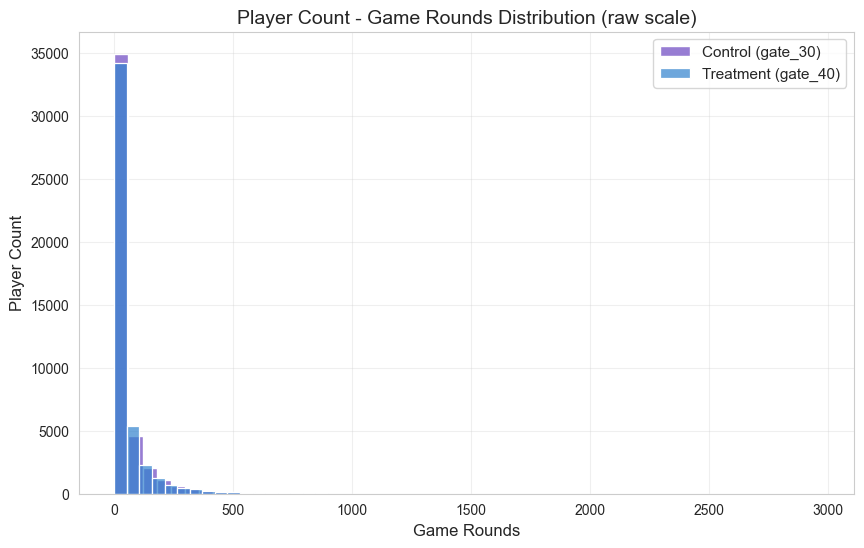

In [64]:
# Plot histogram for control group (gate_30)
sns.histplot(
    data=plot_df[plot_df["version"] == "gate_30"],
    x="sum_gamerounds",
    bins=50,
    alpha=0.7,
    label="Control (gate_30)",
)

# Plot histogram for treatment group (gate_40)
sns.histplot(
    data=plot_df[plot_df["version"] == "gate_40"],
    x="sum_gamerounds",
    bins=50,
    alpha=0.7,
    label="Treatment (gate_40)",
)

plt.title("Player Count - Game Rounds Distribution (raw scale)")
plt.xlabel("Game Rounds")
plt.ylabel("Player Count")
plt.legend()
plt.show()

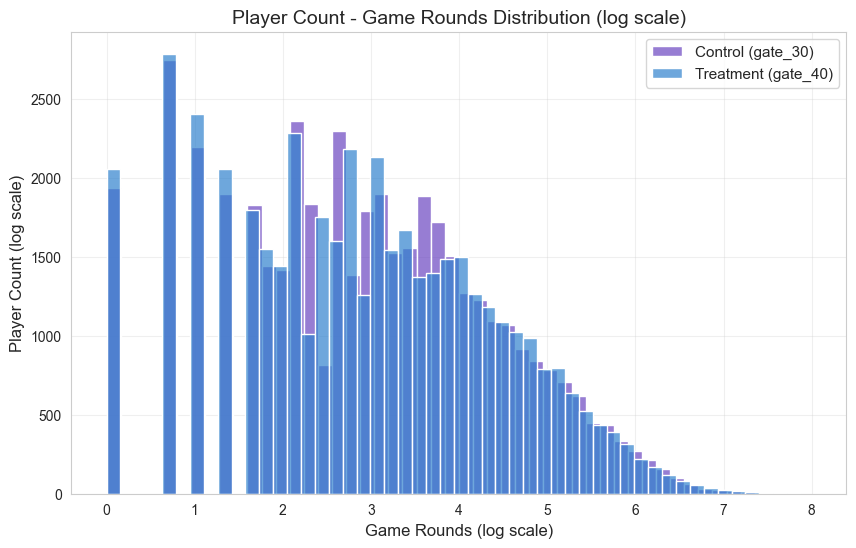

In [65]:
# Plot histogram for control group (gate_30)
sns.histplot(
    data=plot_df[plot_df["version"] == "gate_30"],
    x="log_sum_gamerounds",
    bins=50,
    alpha=0.7,
    label="Control (gate_30)",
)

# Plot histogram for treatment group (gate_40)
sns.histplot(
    data=plot_df[plot_df["version"] == "gate_40"],
    x="log_sum_gamerounds",
    bins=50,
    alpha=0.7,
    label="Treatment (gate_40)",
)

plt.title("Player Count - Game Rounds Distribution (log scale)")
plt.xlabel("Game Rounds (log scale)")
plt.ylabel("Player Count (log scale)")
plt.legend()
plt.show()

### 5. Power analysis & MDE exploration

In [66]:
# Invert Cohen's h to get p1 given p0 and h
def h_to_p1(h, p0):
    return np.sin(np.arcsin(np.sqrt(p0)) + h / 2.0) ** 2

In [67]:
# Baseline p0 (control group day-7 retention)
p0 = cookie_df[cookie_df["version"] == "gate_30"]["retention_7"].mean()
print(f"Baseline p0 (control day-7 retention): {p0:.4f}")

Baseline p0 (control day-7 retention): 0.1902


Minimum Detectable Effect at current sample sizes (80% power, alpha = 0.05)

In [68]:
# Solve for the effect size h required to achieve 80% power at the actual N
N = cookie_df[cookie_df["version"] == "gate_30"].shape[0]  # actual sample size
ratio = 1.0  # balanced planning curve

power_analysis = NormalIndPower()
effectsize_needed = power_analysis.solve_power(
    effect_size=None,
    nobs1=N,
    alpha=alpha,
    power=power,
    ratio=ratio,
    alternative="two-sided",
)

# Convert h back to absolute uplift in percentage points
p1_mde = h_to_p1(effectsize_needed, p0)
mde_pp_current = (p1_mde - p0) * 100
print(
    f"MDE at current N ({N}) (80% power, two-sided alpha=0.05): {mde_pp_current:.4f} pp"
)

MDE at current N (44700) (80% power, two-sided alpha=0.05): 0.7409 pp


Any true lift ≥ 0.74 pp will be detected with ≈80% power.

Required N per group for target MDEs (balanced)

In [69]:
# Choose target MDEs in percentage points (pp)
targets_pp = [0.5, 0.8, 1.0, 1.5, 2.0]

rows = []
for pp in targets_pp:
    # Calculate the required sample size for each target MDE
    p1_target = min(max(p0 + pp / 100.0, 1e-9), 1 - 1e-9)
    effectsize_target = proportion_effectsize(p1_target, p0)
    n_per_group = power_analysis.solve_power(
        effect_size=effectsize_target,
        nobs1=None,
        alpha=alpha,
        power=power,
        ratio=ratio,
        alternative="two-sided",
    )

    rows.append(
        {"Target MDE (pp)": pp, "Required N per group": int(math.ceil(n_per_group))}
    )

required_n_df = pd.DataFrame(rows)
required_n_df

,Target MDE (pp),Required N per group
0,0.5,97679
1,0.8,38380
2,1.0,24658
3,1.5,11063
4,2.0,6281


Power vs. MDE plot

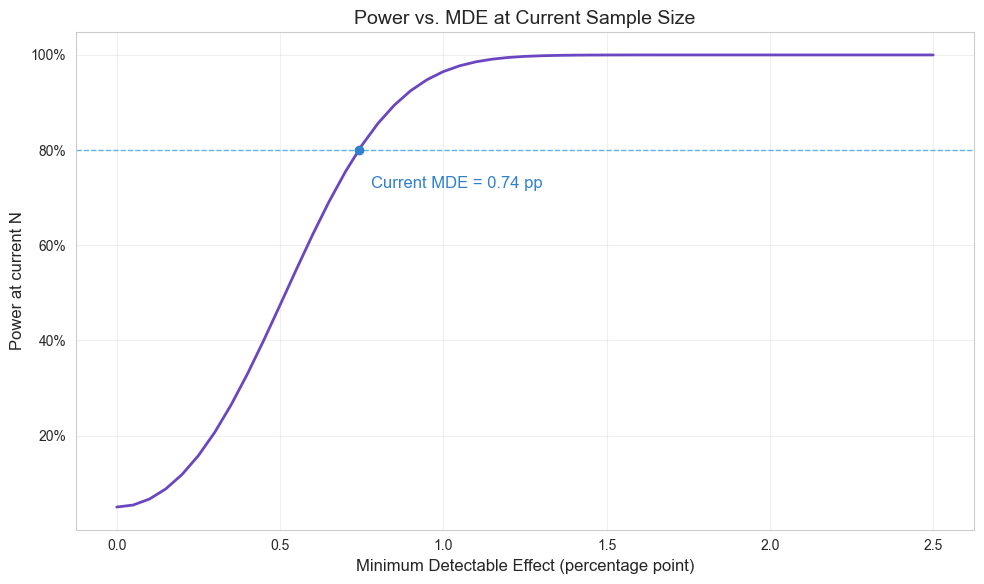

In [70]:
# Plot — Power vs MDE (pp) at current N
uplifts = np.linspace(0, 2.5, 51)
powers = []
for pp in uplifts:
    p1 = min(max(p0 + pp / 100.0, 1e-9), 1 - 1e-9)
    effectsize = proportion_effectsize(p1, p0)
    pw = power_analysis.solve_power(
        effect_size=effectsize,
        nobs1=N,
        alpha=alpha,
        ratio=ratio,
        alternative="two-sided",
    )
    powers.append(pw)


plt.plot(uplifts, powers, color="#6B46C1", linewidth=2)
plt.axhline(0.8, linestyle="--", linewidth=1, color="#63B3ED")

# Add point for current MDE
plt.scatter([mde_pp_current], [0.80], color="#3182CE", zorder=5)
plt.text(
    mde_pp_current + 0.3,
    0.72,
    f"Current MDE = {mde_pp_current:.2f} pp",
    ha="center",
    color="#3182CE",
)

# Format y-axis as percentages
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.xlabel("Minimum Detectable Effect (percentage point)")
plt.ylabel("Power at current N")
plt.title("Power vs. MDE at Current Sample Size")
plt.tight_layout()
plt.show()

The curve crosses 80% power near the computed MDE.

MDE vs. N per group plot (balanced at 80% power)

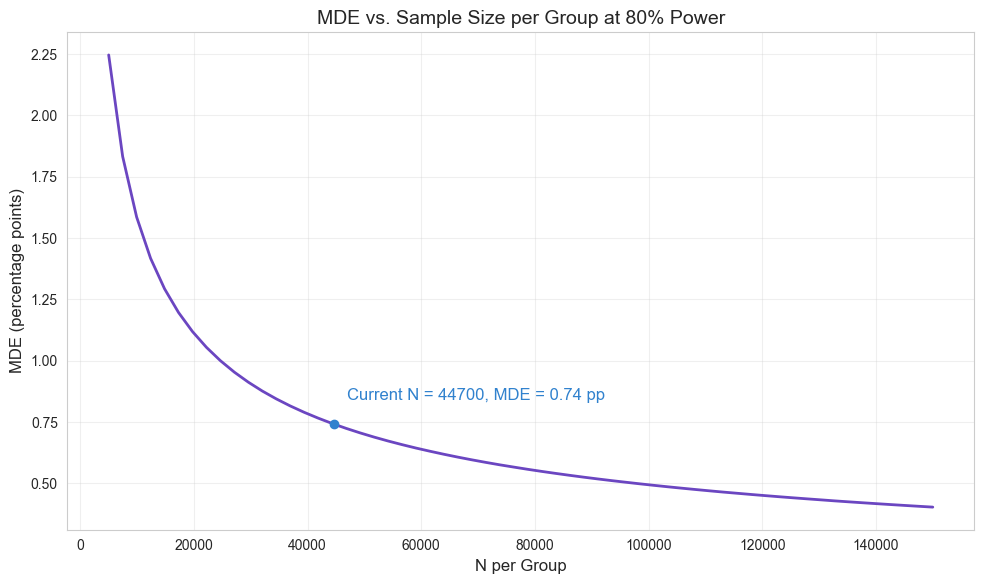

In [71]:
# Plot — MDE vs n per group (balanced @ 80% power)
n_values = np.linspace(5_000, 150_000, 60)  # per-group sizes for planning
pp = []
for n in n_values:
    effectsize_required = power_analysis.solve_power(
        effect_size=None,
        nobs1=n,
        alpha=alpha,
        power=power,
        ratio=ratio,
        alternative="two-sided",
    )
    p1_required = h_to_p1(
        effectsize_required, p0
    )  # invert h to get p1, then convert to pp uplift
    pp.append((p1_required - p0) * 100)

plt.plot(n_values, pp, color="#6B46C1", linewidth=2)

plt.scatter([N], [mde_pp_current], color="#3182CE", zorder=5)
plt.text(
    N + 25000,
    mde_pp_current + 0.1,
    f"Current N = {N}, MDE = {mde_pp_current:.2f} pp",
    ha="center",
    color="#3182CE",
)

plt.xlabel("N per Group")
plt.ylabel("MDE (percentage points)")
plt.title("MDE vs. Sample Size per Group at 80% Power")
plt.tight_layout()
plt.show()

#### Interpretation

While the experiment design aims for 80% power with 1.0 pp MDE, at the current sample size the experiment can detect a more sensitive MDE of 0.74 pp.

### 6. Primary metric analysis: day-7 retention

In [72]:
# Group sizes (gate_30 and gate_40)
print(f"Control group (gate_30) size: {control_players}")
print(f"Treatment group (gate_40) size: {treatment_players}")

# Successes = players retained at day-7
success_ctrl_ret7 = cookie_df[cookie_df["version"] == "gate_30"]["retention_7"].sum()
success_treat_ret7 = cookie_df[cookie_df["version"] == "gate_40"]["retention_7"].sum()

successes = [success_ctrl_ret7, success_treat_ret7]
nobs = [control_players, treatment_players]

# Two-proportion z-test
z_stat_ret7, pval_ret7 = proportions_ztest(successes, nobs, alternative="two-sided")

# Confidence intervals for each group
(ci_ctrl_low_ret7, ci_ctrl_high_ret7) = proportion_confint(
    success_ctrl_ret7, control_players, alpha=alpha, method="wilson"
)
(ci_treat_low_ret7, ci_treat_high_ret7) = proportion_confint(
    success_treat_ret7, treatment_players, alpha=alpha, method="wilson"
)

# Calculate observed proportions and difference
prop_ctrl_ret7 = success_ctrl_ret7 / control_players
prop_treat_ret7 = success_treat_ret7 / treatment_players
delta_ret7 = prop_treat_ret7 - prop_ctrl_ret7
delta_pp_ret7 = delta_ret7 * 100

# Confidence intervals for the difference
(ci_low_delta7, ci_high_delta7) = confint_proportions_2indep(
    success_treat_ret7,
    treatment_players,
    success_ctrl_ret7,
    control_players,
    method="score",
)

# Calculate relative change
rel_pct_ret7 = (prop_treat_ret7 / prop_ctrl_ret7 - 1) * 100

# Cohen's h
p1 = cookie_df[cookie_df["version"] == "gate_40"]["retention_7"].mean()
h = proportion_effectsize(p0, p1)

print(
    f"Control group (gate_30) day-7 retention rate: {prop_ctrl_ret7:.6f} (95% CI [{ci_ctrl_low_ret7:.6f}, {ci_ctrl_high_ret7:.6f}])"
)
print(
    f"Treatment group (gate_40) day-7 retention rate: {prop_treat_ret7:.6f} (95% CI [{ci_treat_low_ret7:.6f}, {ci_treat_high_ret7:.6f}])"
)
print(f"z = {z_stat_ret7:.6f}, p-value = {pval_ret7:.6f}")
print(
    f"Absolute difference: {delta_pp_ret7:.6f} pp (95% CI [{ci_low_delta7 * 100:.3f}, {ci_high_delta7 * 100:.3f}] pp)"
)
print(f"Relative difference: {rel_pct_ret7:.2f}%")
print(f"Effect size (Cohen's h): {h:.6f}")

Control group (gate_30) size: 44700
Treatment group (gate_40) size: 45489
Control group (gate_30) day-7 retention rate: 0.190201 (95% CI [0.186590, 0.193866])
Treatment group (gate_40) day-7 retention rate: 0.182000 (95% CI [0.178481, 0.185573])
z = 3.164359, p-value = 0.001554
Absolute difference: -0.820130 pp (95% CI [-1.328, -0.312] pp)
Relative difference: -4.31%
Effect size (Cohen's h): 0.021074


##### Interpretation

p < 0.05 indicates statistical significance, meaning that there is indeed a difference between gate level versions. The effect is -0.82 pp, which is lower than the pre-specified MDE of 1.0 pp, but Cohen's h = 0.02 indicates a small effect size. In other words, the treatment (``gate_40``) hurts retention relative to control (``gate_30``), albeit in a negligible magnitude.

### 7. Guardrail metrics analyses: day-1 retention & game rounds

#### 7.1 Day-1 retention

In [73]:
# Group sizes (gate_30 and gate_40)
print(f"Control group (gate_30) size: {control_players}")
print(f"Treatment group (gate_40) size: {treatment_players}")

# Successes = players retained at day-1
success_ctrl_ret1 = cookie_df[cookie_df["version"] == "gate_30"]["retention_1"].sum()
success_treat_ret1 = cookie_df[cookie_df["version"] == "gate_40"]["retention_1"].sum()

successes = [success_ctrl_ret1, success_treat_ret1]
nobs = [control_players, treatment_players]

# Two-proportion z-test
z_stat_ret1, pval_ret1 = proportions_ztest(successes, nobs, alternative="two-sided")

# Confidence intervals for each group
(ci_ctrl_low_ret1, ci_ctrl_high_ret1) = proportion_confint(
    success_ctrl_ret1, control_players, alpha=alpha, method="wilson"
)
(ci_treat_low_ret1, ci_treat_high_ret1) = proportion_confint(
    success_treat_ret1, treatment_players, alpha=alpha, method="wilson"
)

# Calculate observed proportions and difference
prop_ctrl_ret1 = success_ctrl_ret1 / control_players
prop_treat_ret1 = success_treat_ret1 / treatment_players
delta_ret1 = prop_treat_ret1 - prop_ctrl_ret1
delta_pp_ret1 = delta_ret1 * 100

# Confidence intervals for the difference
(ci_low_delta1, ci_high_delta1) = confint_proportions_2indep(
    success_treat_ret1,
    treatment_players,
    success_ctrl_ret1,
    control_players,
    method="score",
)

print(
    f"Control group (gate_30) day-1 retention rate: {prop_ctrl_ret1:.6f} 95% CI [{ci_ctrl_low_ret1:.6f}, {ci_ctrl_high_ret1:.6f}]"
)
print(
    f"Treatment group (gate_40) day-1 retention rate: {prop_treat_ret1:.6f} 95% CI [{ci_treat_low_ret1:.6f}, {ci_treat_high_ret1:.6f}]"
)
print(f"Difference in day-1 retention: {delta_pp_ret1:.6f} pp")
print(f"z = {z_stat_ret1:.6f}, p-value = {pval_ret1:.6f}")

Control group (gate_30) size: 44700
Treatment group (gate_40) size: 45489
Control group (gate_30) day-1 retention rate: 0.448188 95% CI [0.443582, 0.452802]
Treatment group (gate_40) day-1 retention rate: 0.442283 95% CI [0.437724, 0.446851]
Difference in day-1 retention: -0.590517 pp
z = 1.784086, p-value = 0.074410


##### Interpretation

Indicated by a large p=0.074410, there may be no statistically significant difference between experiment groups in day-1 retention.

#### 7.2 Game rounds

Heavy-tailed (right / positive skew), non-parametric + log-transform

In [74]:
# Game rounds played per version
rounds_ctrl = cookie_df[cookie_df["version"] == "gate_30"]["sum_gamerounds"]
rounds_treat = cookie_df[cookie_df["version"] == "gate_40"]["sum_gamerounds"]

# Mann-Whitney U test
u_stat, pval_rounds = mannwhitneyu(rounds_ctrl, rounds_treat, alternative="two-sided")

# Engagement statistics for context
mean_ctrl = rounds_ctrl.mean()
median_ctrl = rounds_ctrl.median()
mean_treat = rounds_treat.mean()
median_treat = rounds_treat.median()
delta_mean = mean_treat - mean_ctrl

print(f"Control (gate_30) mean: {mean_ctrl:.2f}, median: {median_ctrl:.2f}")
print(f"Treatment (gate_40) mean: {mean_treat:.2f}, median: {median_treat:.2f}")
print(f"Mann-Whitney U statistic: {u_stat:.0f}, p-value: {pval_rounds:.6f}")
print(f"Absoulute difference in mean game rounds: {delta_mean:.2f}")

Control (gate_30) mean: 52.46, median: 17.00
Treatment (gate_40) mean: 51.30, median: 16.00
Mann-Whitney U statistic: 1024331250, p-value: 0.050209
Absoulute difference in mean game rounds: -1.16


In [75]:
# Transform game rounds
log_ctrl = np.log1p(rounds_ctrl)
log_treat = np.log1p(rounds_treat)

# Welch's t-test (unequal variances)
tstat_log, pval_log = ttest_ind(
    log_ctrl, log_treat, equal_var=False, alternative="two-sided"
)

print(
    f"Welch's t-test on log-transformed rounds t-statistic = {tstat_log:6f}, p-value = {pval_log:6f}"
)
print(f"Control (gate_30) log mean = {log_ctrl.mean():6f}")
print(f"Treatment (gate_40) log mean = {log_treat.mean():6f}")

Welch's t-test on log-transformed rounds t-statistic = 1.814246, p-value = 0.069643
Control (gate_30) log mean = 2.888910
Treatment (gate_40) log mean = 2.870742


Bootstrap 95% CI for mean difference

In [76]:
# Simple percentile bootstrap for the mean difference on the raw scale
np.random.seed(42)
B = 5000
boot_diffs = []

for i in range(B):
    # Resample with replacement from both groups
    ctrl_sample_mean = rounds_ctrl.sample(n=len(rounds_ctrl), replace=True).mean()
    treat_sample_mean = rounds_treat.sample(n=len(rounds_treat), replace=True).mean()
    boot_diffs.append(ctrl_sample_mean - treat_sample_mean)

boot_diffs = np.array(boot_diffs)
ci_low, ci_high = np.percentile(boot_diffs, [2.5, 97.5])
obs_diff = rounds_treat.mean() - rounds_ctrl.mean()

print(f"Mean difference: {obs_diff:.2f}")
print(f"Bootstrap 95% CI for mean difference: [{ci_low:.2f}, {ci_high:.2f}]")

Mean difference: -1.16
Bootstrap 95% CI for mean difference: [-1.04, 4.05]


##### Interpretation

Across all three methods (MWU, Welch t, bootstrap CI), results consistently demonstrate:
- No significant difference between ``gate_30`` and ``gate_40`` in game rounds played.
- Effect size is negligible in practice (less than ±1–2 rounds out of ~50 average).
- In other words, changing the gate does not affect overall engagement measured by total rounds played.

### 8. Multiple testing correction

In [77]:
# Guardrail p-values
guardrail_unadj = [pval_ret1, pval_rounds, pval_log]

# Perform Holm correction
guardrail_adj = multipletests(guardrail_unadj, alpha=alpha, method="holm")

print(f"Significant tests: {guardrail_adj[0]}")
print(f"Corrected p-values: {guardrail_adj[1]}")

Significant tests: [False False False]
Corrected p-values: [0.15062642 0.15062642 0.15062642]


### 9. Results summary table

In [78]:
# Prepare results for reporting
results_df = pd.DataFrame(
    [
        {
            "Metric": "Day-7 Retention (Primary)",
            "Control (gate_30)": f"{prop_ctrl_ret7:.2f} 95% CI [{ci_ctrl_low_ret7:.4f}, {ci_ctrl_high_ret7:.4f}]",
            "Treatment (gate_40)": f"{prop_treat_ret7:.2f} 95% CI [{ci_treat_low_ret7:.4f}, {ci_treat_high_ret7:.4f}]",
            "Absolute Δ": f"{delta_pp_ret7:.2f} pp [{ci_low_delta7 * 100:.2f}, {ci_high_delta7 * 100:.2f}]",
            "Statistic": f"z = {z_stat_ret7:.6f}",
            "p-value": pval_ret7, 
            "Adjusted p-value": None,
            "Notes": f"Relative Δ: {rel_pct_ret7:.2f}%, Cohen's h: {h:.6f}",
        },
        {
            "Metric": "Day-1 Retention",
            "Control (gate_30)": f"{prop_ctrl_ret1:.2f} 95% CI [{ci_ctrl_low_ret1:.4f}, {ci_ctrl_high_ret1:.4f}]",
            "Treatment (gate_40)": f"{prop_treat_ret1:.2f} 95% CI [{ci_treat_low_ret1:.4f}, {ci_treat_high_ret1:.4f}]",
            "Absolute Δ": f"{delta_pp_ret1:.2f} pp [{ci_low_delta1 * 100:.2f}, {ci_high_delta1 * 100:.2f}]",
            "Statistic": f"z = {z_stat_ret1:.6f}",
            "p-value": pval_ret1,
            "Adjusted p-value": guardrail_adj[1][0],
            "Notes": "Holm-adjusted within guardrail family",
        },
        {
            "Metric": "Game rounds (MWU)",
            "Control (gate_30)": f"mean = {mean_ctrl:.2f}, median = {median_ctrl:.2f}",
            "Treatment (gate_40)": f"mean = {mean_treat:.2f}, median = {median_treat:.2f}",
            "Absolute Δ": f"{delta_mean:.2f}",
            "Statistic": f"U = {u_stat:.0f}",
            "p-value": pval_rounds,
            "Adjusted p-value": guardrail_adj[1][1],
            "Notes": "Heavy-tailed, non-parametric",
        },
        {
            "Metric": "Game rounds (log1p, Welch t)",
            "Control (gate_30)": f"mean = {log_ctrl.mean():.4f}",
            "Treatment (gate_40)": f"mean = {log_treat.mean():.4f}",
            "Absolute Δ": None,
            "Statistic": f"t = {tstat_log:.4f}",
            "p-value": pval_log,
            "Adjusted p-value": guardrail_adj[1][2],
            "Notes": "Log scale to normalize distribution",
        },
        {
            "Metric": "Bootstrap delta mean rounds",
            "Control (gate_30)": f"{ctrl_sample_mean:.2f}",
            "Treatment (gate_40)": f"{treat_sample_mean:.2f}",
            "Absolute Δ": f"{obs_diff:.2f}",
            "Statistic": f"95% CI for mean difference: [{ci_low:.2f}, {ci_high:.2f}]",
            "p-value": None,
            "Adjusted p-value": None,
            "Notes": "",
        },
    ]
)

In [79]:
results_df

,Metric,Control (gate_30),Treatment (gate_40),Absolute Δ,Statistic,p-value,Adjusted p-value,Notes
0,Day-7 Retention (Primary),"0.19 95% CI [0.1866, 0.1939]","0.18 95% CI [0.1785, 0.1856]","-0.82 pp [-1.33, -0.31]",z = 3.164359,0.001554,NaN,"Relative Δ: -4.31%, Cohen's h: 0.021074"
1,Day-1 Retention,"0.45 95% CI [0.4436, 0.4528]","0.44 95% CI [0.4377, 0.4469]","-0.59 pp [-1.24, 0.06]",z = 1.784086,0.074410,0.150626,Holm-adjusted within guardrail family
2,Game rounds (MWU),"mean = 52.46, median = 17.00","mean = 51.30, median = 16.00",-1.16,U = 1024331250,0.050209,0.150626,"Heavy-tailed, non-parametric"
3,"Game rounds (log1p, Welch t)",mean = 2.8889,mean = 2.8707,None,t = 1.8142,0.069643,0.150626,Log scale to normalize distribution
4,Bootstrap delta mean rounds,52.91,51.39,-1.16,"95% CI for mean difference: [-1.04, 4.05]",NaN,NaN,


In [80]:
def decide(pval_ret7, delta_pp_ret7, mde_pp, alpha):
    if pval_ret7 < alpha:
        if delta_pp_ret7 >= mde_pp:
            return "Roll out"
        if delta_pp_ret7 <= -mde_pp:
            return "Do not roll out, treatment harmful beyond MDE"
        return "Significant but below MDE, do not roll out"
    return "No effect, do not roll out"


print("Decision:", decide(pval_ret7, delta_pp_ret7, mde_pp, alpha))

Decision: Significant but below MDE, do not roll out


### 10. Business impact projection

In [81]:
# Calculate the number of retained players at Day-7 per 100,000 new players
K = 100_000

delta_retained = K * (prop_treat_ret7 - prop_ctrl_ret7)
ci_players = (K * ci_low_delta7, K * ci_high_delta7)
print(
    f"Retained players at Day-7 per {K:,} new players: {delta_retained:.0f} [{ci_players[0]:.0f}, {ci_players[1]:.0f}]"
)

# Calculate the approximate revenue impact per 100,000 new players
ARPU_7 = 0.50
print(f"Approximate revenue impact per {K:,} players: ${delta_retained * ARPU_7:.0f}")

Retained players at Day-7 per 100,000 new players: -820 [-1328, -312]
Approximate revenue impact per 100,000 players: $-410


### 11. Conclusion
- **Primary Metric**: Moving the gate from level 30 to level 40 **reduces Day-7 retention by 0.82 percentage points**
- **Statistical Significance**: Highly significant (p = 0.0016)
- **Effect**: Below the pre-specified MDE threshold of 1.0 percentage points

**Decision:**
**Do not roll out** the treatment. While the effect is statistically significant, it fails to meet the business threshold for implementation and actually harms retention.

#### 11.1 Limitations & next steps

- **No timestamps in dataset:** cannot perform time-to-event analysis.
- **No covariates:** cannot adjust for potential confounding or run subgroup analysis.
- **No exposure flag:** results are population estimates, effect may be diluted if many users never reach the gate.
- **No revenue data:** business-impact projection is illustrative and requires real ARPU values.

In [ ]:
# Save the results table to a CSV file
# results_df.to_csv(r"reports/results_table.csv", index=False)